In [1]:
import torch 
from IPython import display
import useTool as ut
import drawPlot
import FashionMnistTool as fmt

In [2]:
batch_size = 256
train_iter, test_iter = fmt.load_data_fashion_mnist(batch_size)

* 展平每个图像，将它们视为长度为784的向量。（可能会损失空间信息）
* 因为我们的数据集有10个类别，所以网络输出维度为10。

In [3]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, 
                 size=(num_inputs, num_outputs), # 行数为输入的个数（784），列数为输出的个数（10）
                 requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

给定⼀个矩阵X，我们可以对所有元素求和（默认情况下）。

In [4]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X, X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[1., 2., 3.],
         [4., 5., 6.]]),
 tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

对每一行做softmax

In [5]:
def softmax(X): 
    X_exp = torch.exp(X) # 对每一个元素做指数计算
    partition = X_exp.sum(1, keepdim=True) # 把每一行求和
    return X_exp / partition # 这⾥应⽤了⼴播机制，每个元素厨艺partition中第i个元素

将每个元素变成一个非负数。此外，依据概率论原理，每行总和为1。

In [6]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.4009, 0.0877, 0.1678, 0.1684, 0.1753],
         [0.2076, 0.1608, 0.0472, 0.5337, 0.0507]]),
 tensor([1., 1.]))

# 实现softomax回归模型

In [7]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [8]:
y = torch.tensor([0, 2]) # 长度为2的向量
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]]) # 前者为第0样本的预测值，后者为第1样本的预测值
y_hat[[0, 1], y] # 第0个样本中第0个类的概率和第1个样本中第2个类的概率

tensor([0.1000, 0.5000])

# 实现交叉熵损失函数

In [9]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y) # 得到的是样本0的损失和样本1的损失

tensor([2.3026, 0.6931])

将预测类比与真实y元素进行比较

In [10]:
ut.accuracy(y_hat, y) / len(y) # 预测正确的样本数 / y的数量 = 预测正确的概率

0.5

In [11]:
ut.evaluate_accuracy(net, test_iter)

0.0902

# Softmax回归的训练

In [12]:
def train_epoch_ch3(net, train_iter, loss, updater): 
    """训练模型⼀个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module): # 如果使用nn.Module
        net.train() # 开启训练模式
    # 训练损失总和、训练准确度总和、样本数
    metric = ut.Accumulator(3) # 使用长度为3的迭代器
    for X, y in train_iter: # 扫一遍数据
        # 计算梯度并更新参数
        y_hat = net(X) # 先计算y_hat
        l = loss(y_hat, y) # 交叉熵损失
        if isinstance(updater, torch.optim.Optimizer):
            # 使⽤PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使⽤定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), ut.accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [13]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    """训练模型"""
    animator = drawPlot.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], 
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = ut.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [14]:
lr = 0.1

def updater(batch_size):
    return ut.sgd([W, b], lr, batch_size)

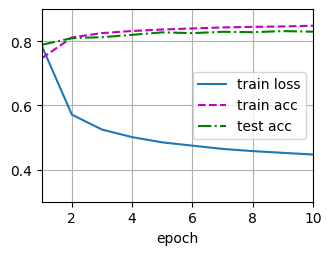

In [15]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

# 预测

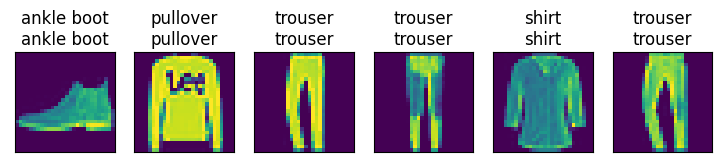

In [17]:
def predict_ch3(net, test_iter, n=6): 
    """预测标签（定义⻅第3章）"""
    for X, y in test_iter:
        break
    trues = fmt.get_fashion_mnist_labels(y)
    preds = fmt.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    ut.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)